In [1]:
import os
import mlflow
os.environ["KERAS_BACKEND"] = "torch"
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plot
import temporal_fusion_transformers as tft
from temporal_fusion_transformers import TFT

os.environ["MLFLOW_TRACKING_URI"] = "https://mlflow-server-med-jupyter-central-dev.apps.dev.ocp.bisinfo.org"

import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(12, 4))
sns.mpl.rc("font", size=12)

In [33]:
country = "US"
n_months_ahead = 2
start_date = "2010-01-01"
end_date = "2023-11-01"

In [34]:
def load_keras(run_id: str, artifact_path: str="model.keras"):
    return mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path=artifact_path)

def load_keras_weights(run_id: str, artifact_path: str="model.keras"):
    return mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path=artifact_path)

In [35]:
parent_id = mlflow.search_runs(
    experiment_ids="4",
    order_by=["created DESC"],
    filter_string = "`Run Name`='Parent run'",
    max_results=1
).run_id.values[0]

In [36]:
runs = mlflow.MlflowClient().search_runs(experiment_ids="4", filter_string=f"tags.mlflow.parentRunId = '{parent_id}'")

In [37]:
def hack_build(model):
    x, _ = tft.prepare_data_samples(
        n_samples=1,
        df_daily_input=tft.df_input_scl,
        df_target=tft.df_target_1m_pct,
        sampled_day="2000-01-01",
        min_context=365,
        context_length=365,
        country="US"
    )
    model(x)
    

In [38]:
models = {}
for run in runs:
    if "TFT" in run.info.run_name:
        ret = load_keras(run.info.run_id)
        model = keras.models.load_model(ret)
        hack_build(model)
        weights = load_keras(run.info.run_id, "tft.weights.h5")
        try:
            model.load_weights(weights)
        except:
            pass
    else:
        model_path = f"runs:/{run.info.run_id}/model"
        model=mlflow.statsmodels.load_model(model_path)
    models[run.info.run_name] = model


/opt/app-root/src/jupyter_workspace/share/nowcasting/NowcastML/nowcastenv/lib64/python3.9/site-packages/keras/src/saving/saving_lib.py:388: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 332 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
100%|██████████| 1/1 [00:00<00:00, 218.04it/s]


/opt/app-root/src/jupyter_workspace/share/nowcasting/NowcastML/nowcastenv/lib64/python3.9/site-packages/keras/src/saving/saving_lib.py:388: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 332 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


/opt/app-root/src/jupyter_workspace/share/nowcasting/NowcastML/nowcastenv/lib64/python3.9/site-packages/keras/src/saving/saving_lib.py:388: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 264 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
100%|██████████| 1/1 [00:00<00:00, 191.53it/s]


/opt/app-root/src/jupyter_workspace/share/nowcasting/NowcastML/nowcastenv/lib64/python3.9/site-packages/keras/src/saving/saving_lib.py:388: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 264 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [39]:
tft.dates_train[np.random.randint(0, high=len(tft.dates_train))]

Timestamp('2001-03-27 00:00:00', freq='D')

In [40]:
from plot import get_monthly_target_df

In [53]:
def build_n_months_prediction_df(
    model,
    n_months_ahead: int,
    country: str,
    start_date: str,
    end_date: str):
    res = {"date": [], "TFT prediction": []}
    y_pred = plot.predictions(model, country, start_date, end_date)
    # Select only the n months ahead from the prediction (and the first and only batch)
    y_pred_ahead = y_pred[:,:n_months_ahead,:]
    for imonth, month in enumerate(plot.loop_over_month_starts(start_date, end_date)):
        pred_df = pd.DataFrame(
            data=y_pred_ahead[imonth],
            columns=[f"quantile_{q:.2f}" for q in tft.quantiles],
            index = plot.create_monthly_index(month, n_months_ahead)
        )
        # Join this with the 12 - n_months_ahead previous months of truth
        start_idx = tft.df_target_1m_pct.index.get_loc(month)
        prev_months_truth = tft.df_target_1m_pct.iloc[start_idx - (12 - n_months_ahead): start_idx][country].rename("inflation")
        # We have no true quantiles in the past -> broadcast the truth to the quantile columns
        df = pd.concat((pd.DataFrame(prev_months_truth), pred_df))
        for q in tft.quantiles:
            df[f"quantile_{q:.2f}"].fillna(df["inflation"], axis=0, inplace=True)
        df["inflation"].fillna(df["quantile_0.50"], inplace=True)
        df_roll = plot.yoy_rolling(df)
        # inflation prediction for this month is the last row
        res["date"].append(month)
        res["TFT prediction"].append(df_roll.iloc[-1].inflation)
    return pd.DataFrame(res).set_index("date")

In [54]:
y = build_n_months_prediction_df(models["TFT_full"], 2, "DE", start_date, end_date)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 610ms/step


In [80]:
from statsmodels.tsa.ar_model import AutoReg

# generate AR forecasts
def generate_ar_forecast(
    start_date: str,
    end_date: str,
    country: str,
    n_months_ahead: int):
    
    df_target=tft.df_target_1m_pct.dropna()
    # Silence
    df_target.index.freq="MS"
    predictions = []
    for month in plot.loop_over_month_starts(start_date, end_date):
        # Get index of current target month and fit model 
        idx = df_target.index.get_loc(month)
        data = df_target.iloc[:idx][country]
        model = AutoReg(data, 12)
        result = model.fit()
        prediction = result.forecast(steps=n_months_ahead)
        # Join this with the 12 - n_months_ahead previous months of truth
        prev_months_truth = df_target[idx - (12 - n_months_ahead): idx][country]
        all_months = pd.concat((prev_months_truth, prediction))
        x = plot.yoy_rolling(all_months)
        predictions.append((month, x.iloc[-1]))
    return pd.DataFrame(predictions).set_index(0).rename(columns={1: "prediction AR"})

In [81]:
generate_ar_forecast(start_date, end_date, country)

TypeError: generate_ar_forecast() missing 1 required positional argument: 'n_months_ahead'

In [82]:
def yoy_plot(start_date: str, end_date: str, country: str, n_months_ahead: int):
    ar_forecasts = generate_ar_forecast(start_date, end_date, country, n_months_ahead)
    truths = tft.df_target_12m_pct.loc[start_date:end_date,country].rename("truth")
    tft_pred = build_n_months_prediction_df(models["TFT_full"], n_months_ahead, country, start_date, end_date)
    fig, ax = plt.subplots()
    ax.set_title(f"{n_months_ahead} months ahead yoy growth, {country}")
    ax.set_ylabel
    tft_pred.plot(ax=ax, label="prediction")
    ar_forecasts.plot(ax=ax, label="prediction AR")
    truths.plot(ax=ax, label="Truth")
    ax.legend()
    ax.axvline(pd.Timestamp("2018-01-01"), ls="--", color="gray")

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 606ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 606ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 609ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 609ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 606ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 606ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 609ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 610ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 607ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 609ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 610ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 655ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 607ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 609ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 607ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step


/tmp/ipykernel_212781/267236104.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 609ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 609ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 610ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 610ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 609ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 606ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 607ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 607ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 607ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 608ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 612ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 610ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 615ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step


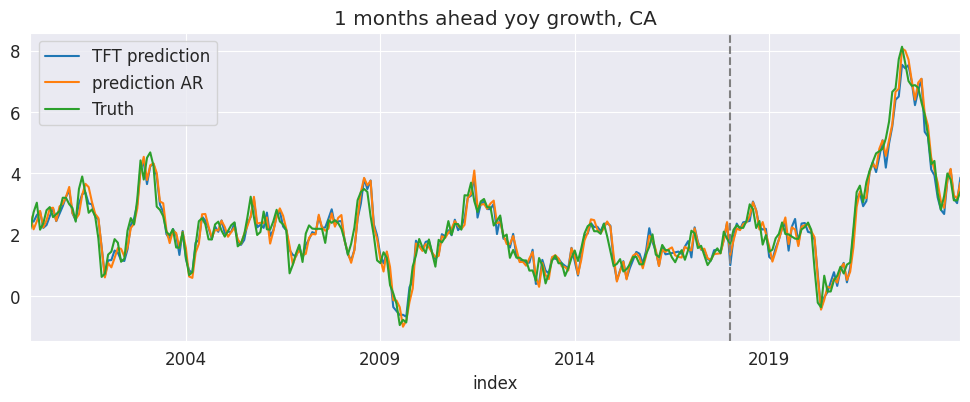

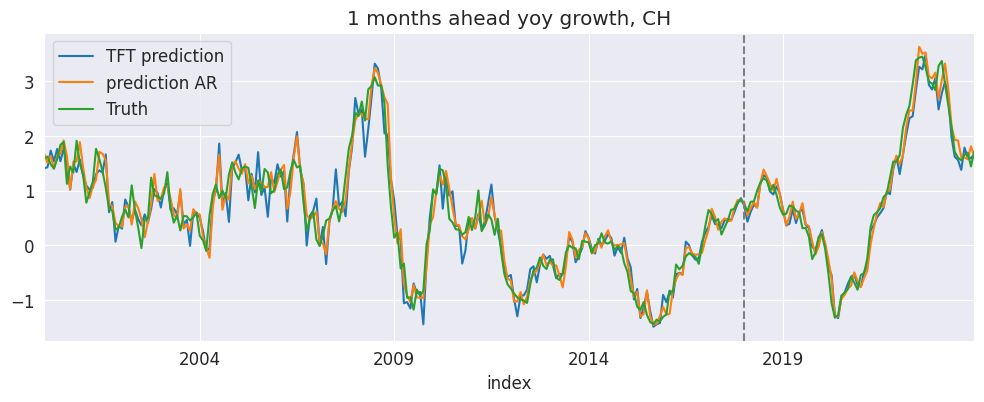

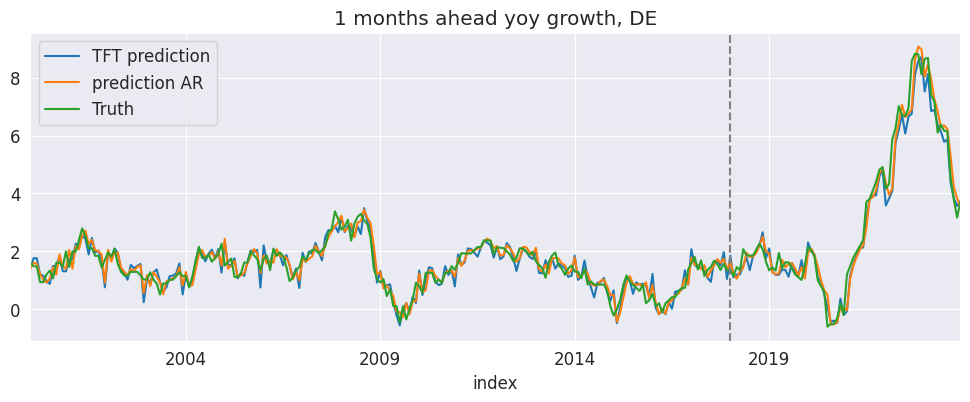

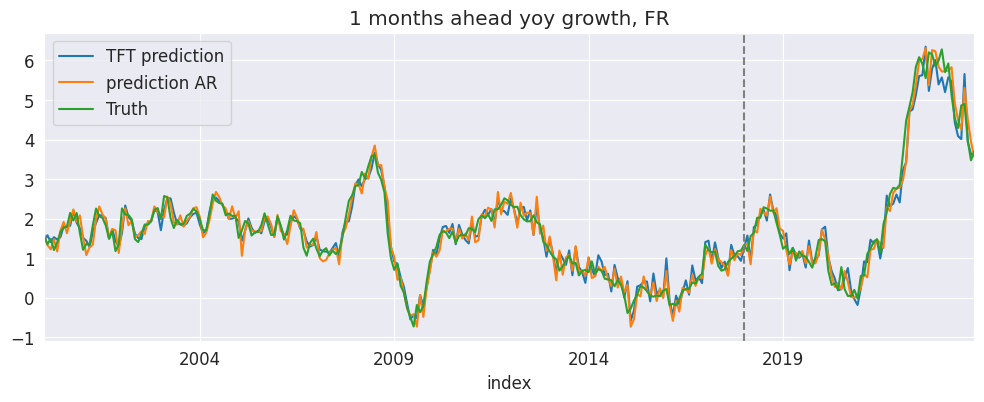

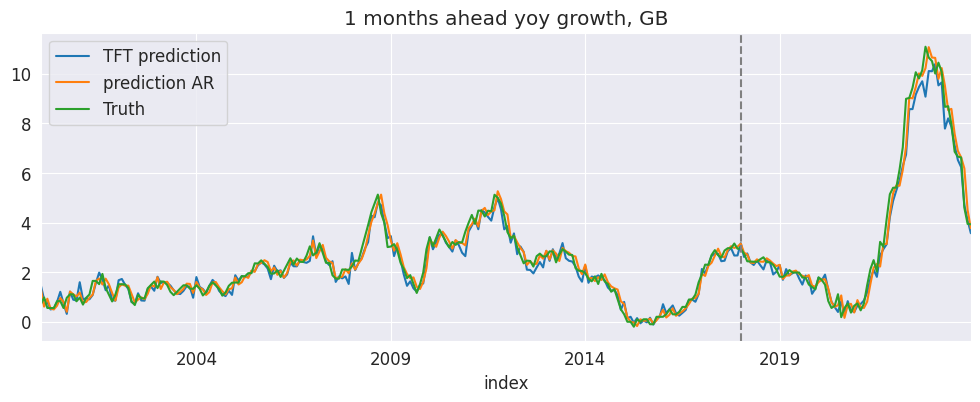

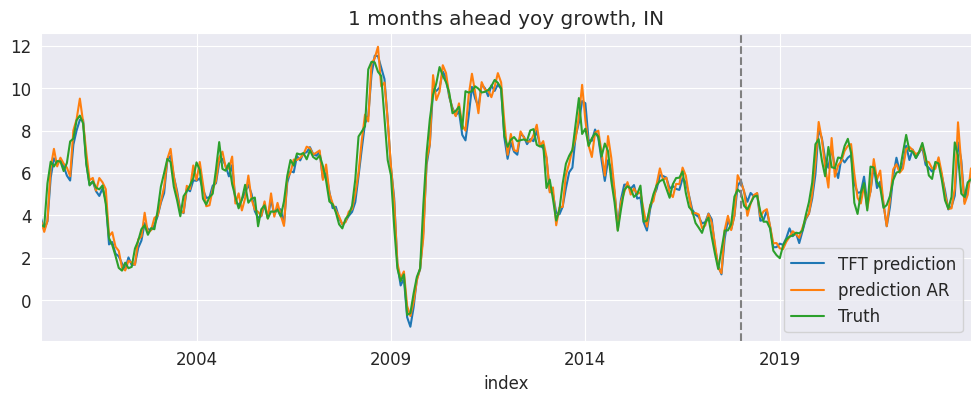

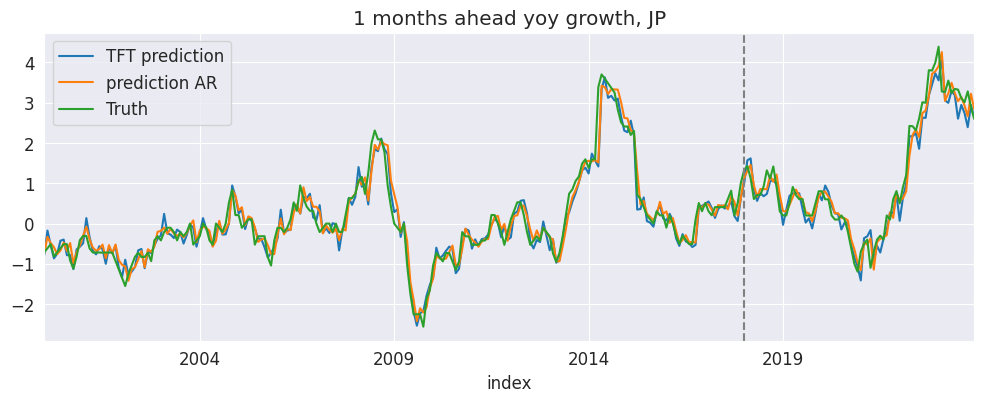

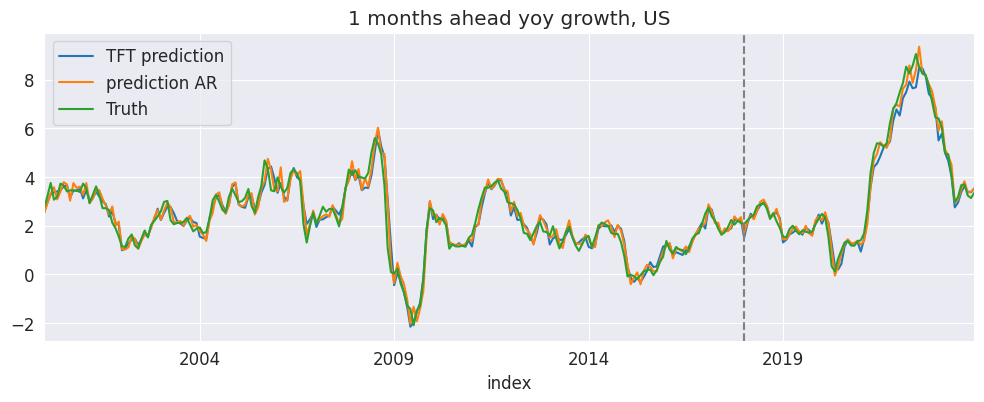

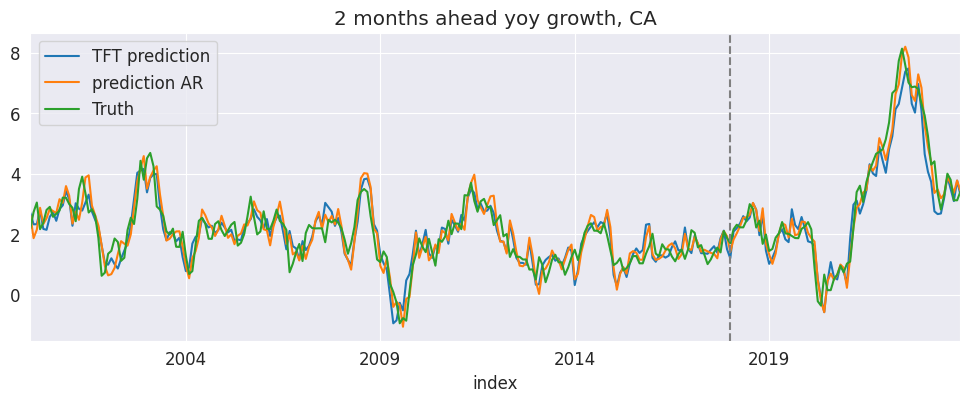

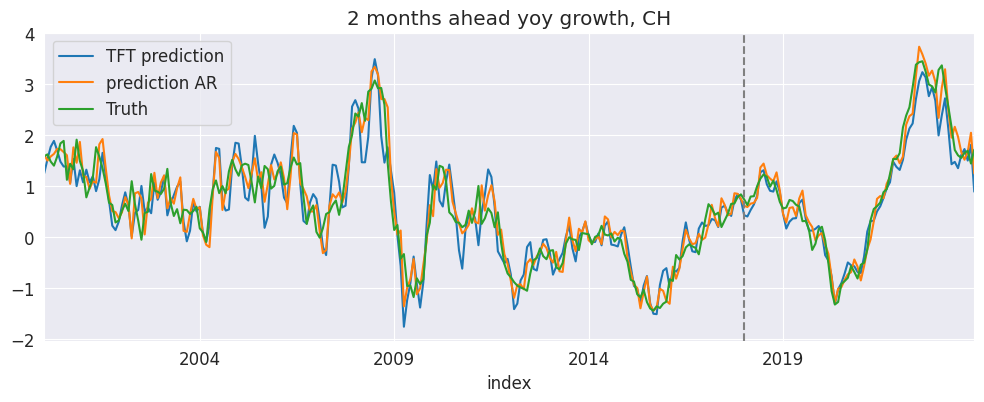

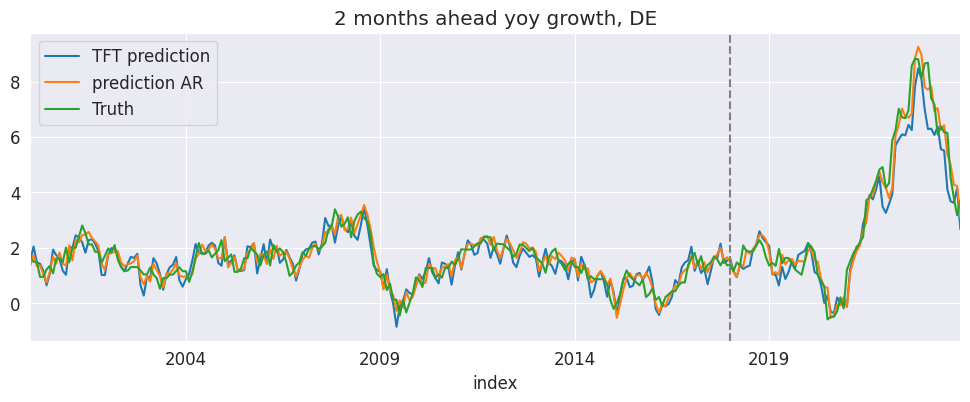

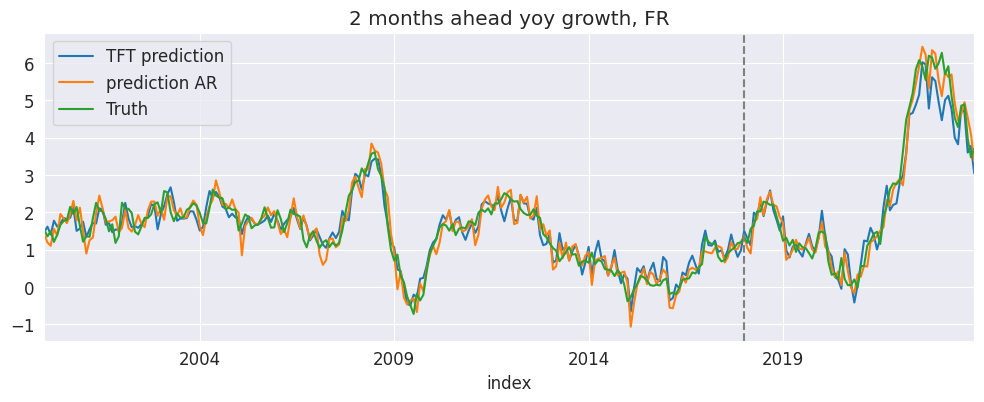

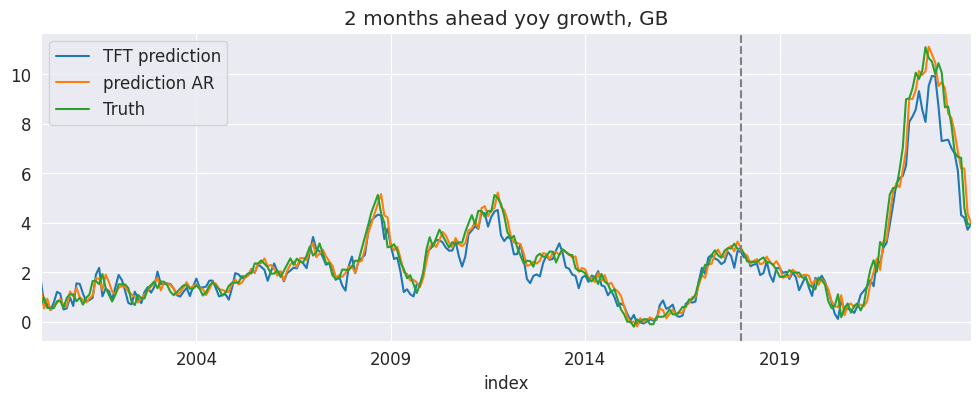

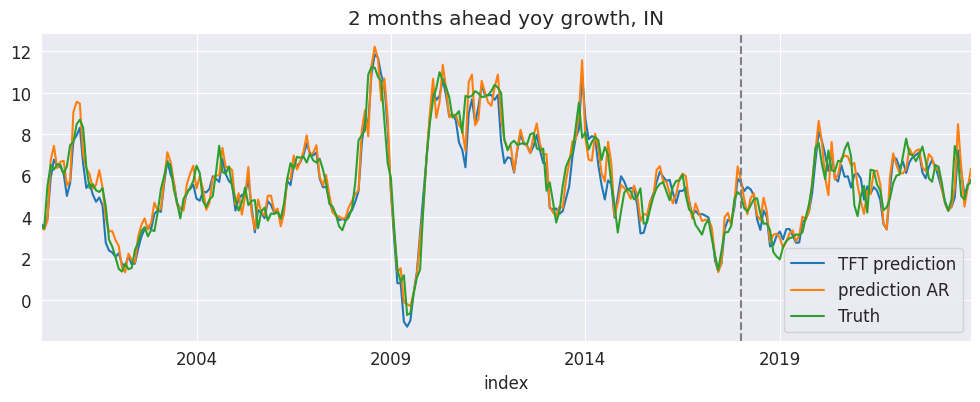

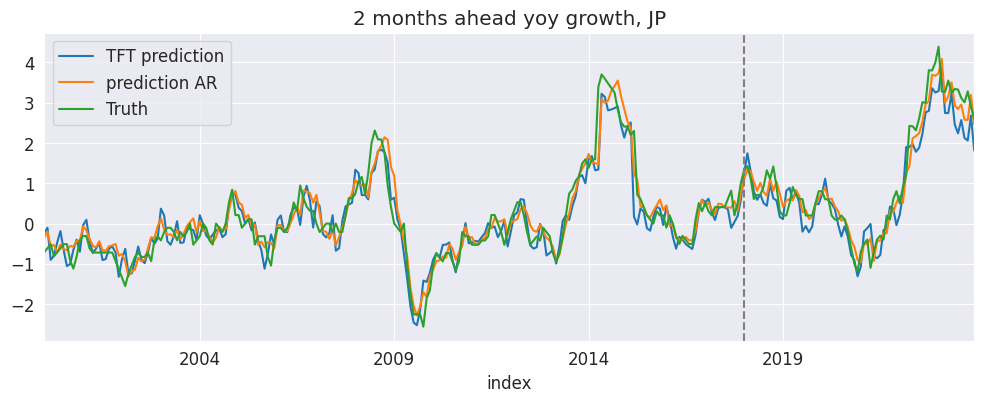

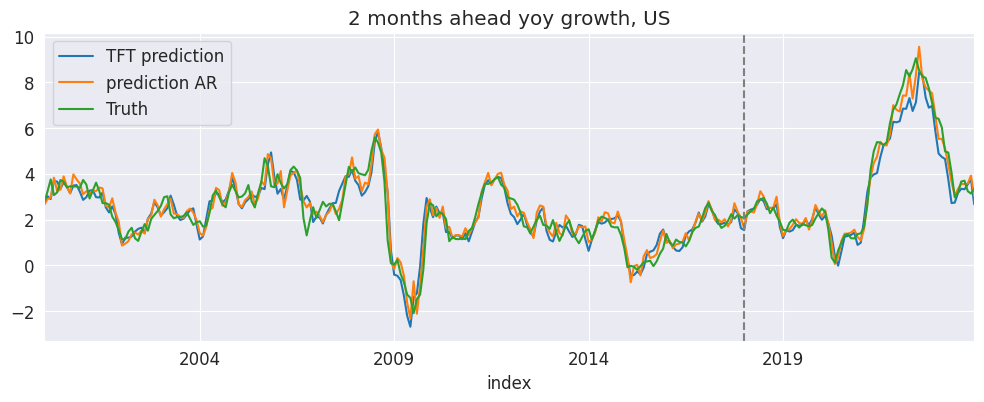

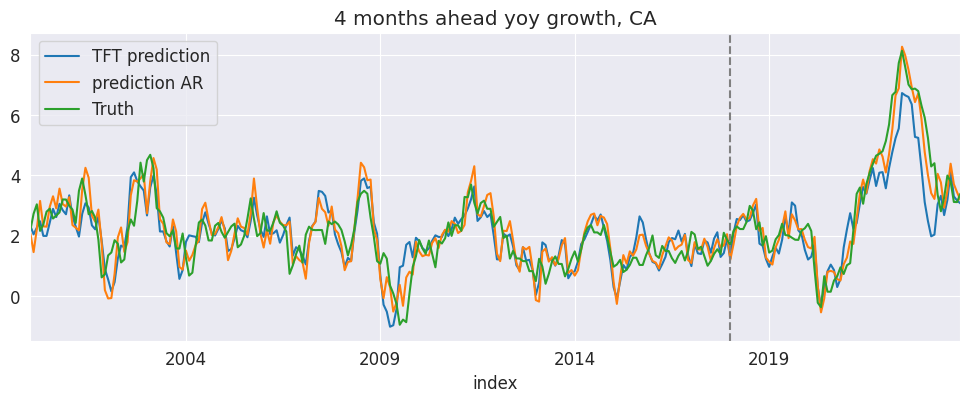

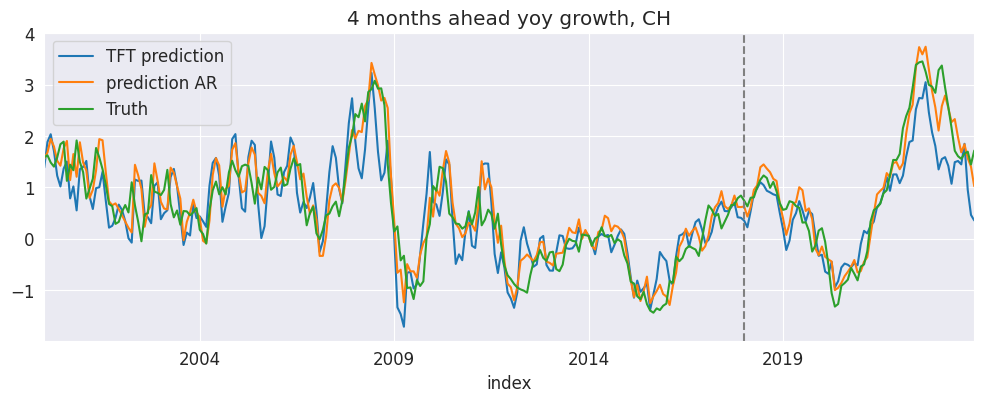

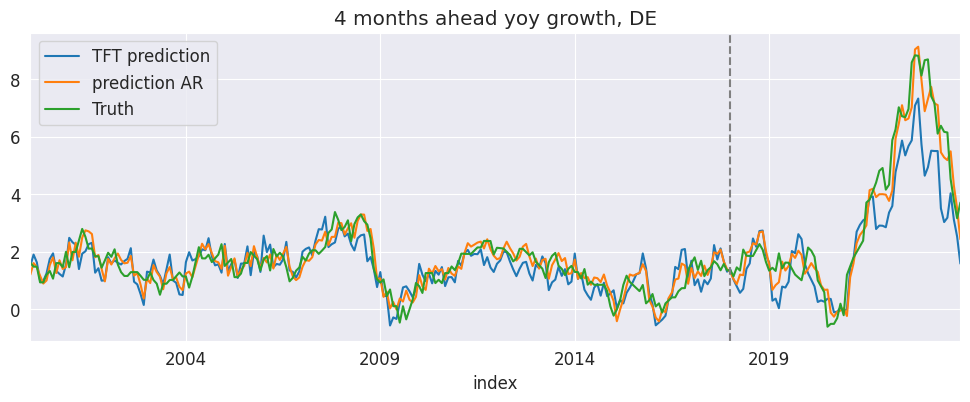

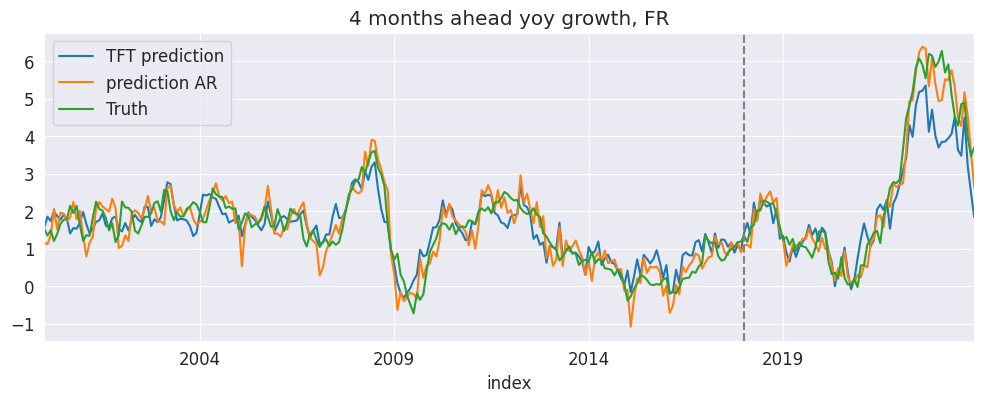

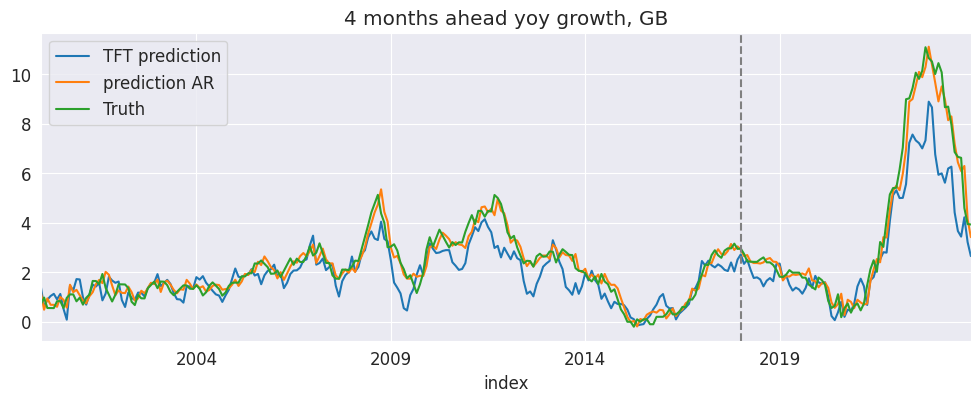

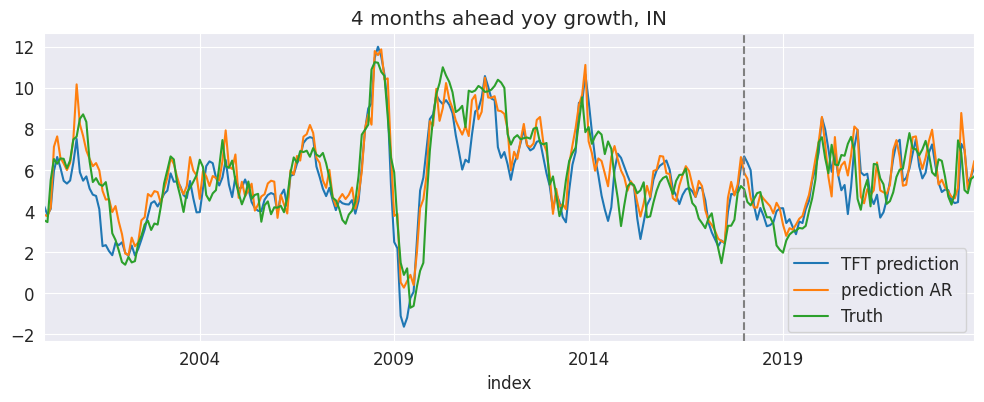

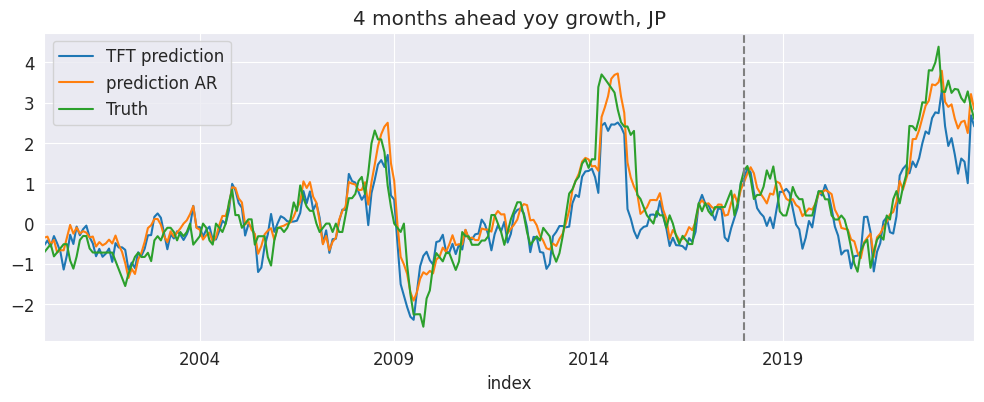

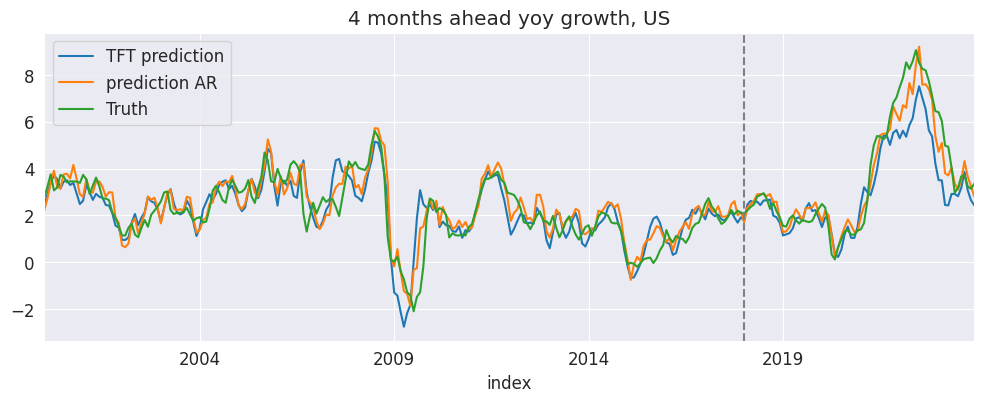

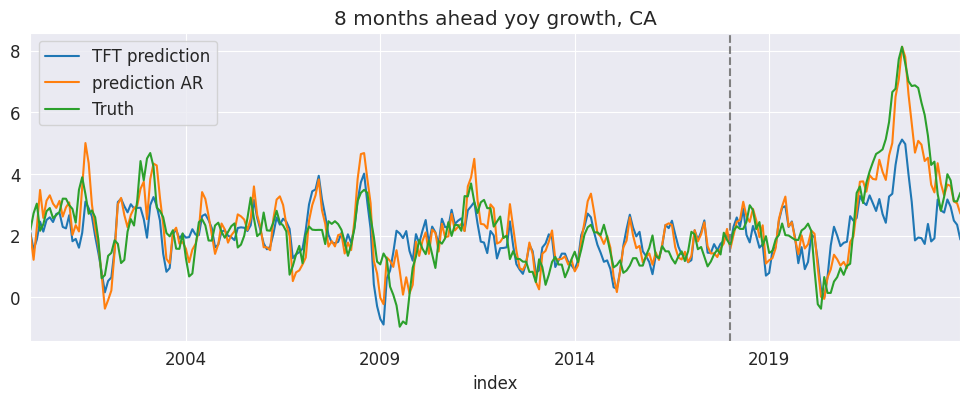

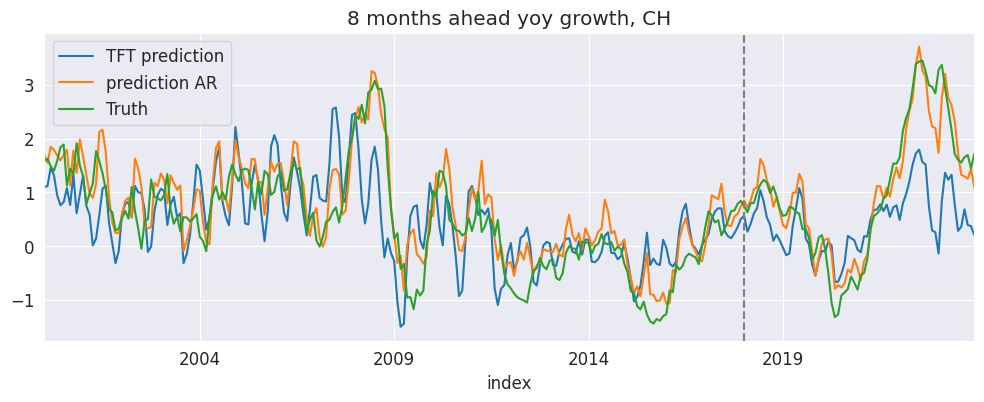

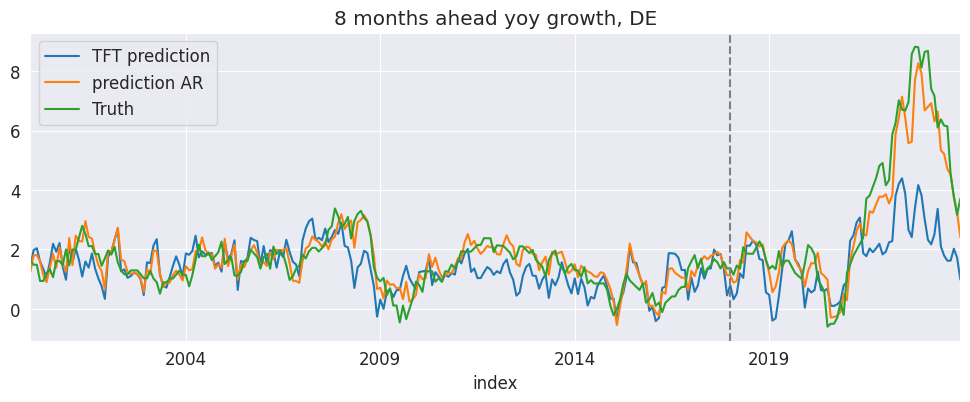

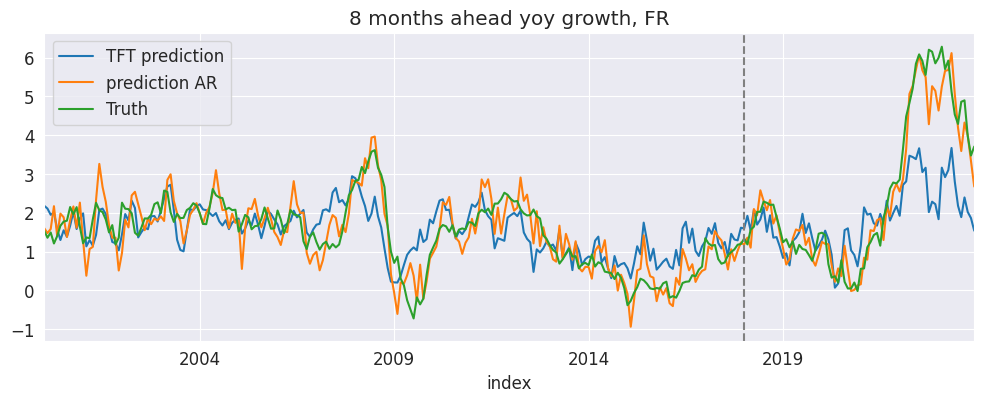

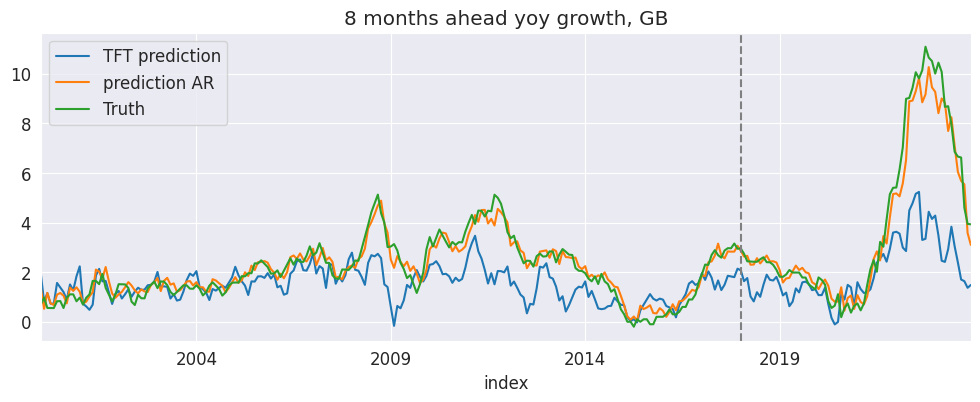

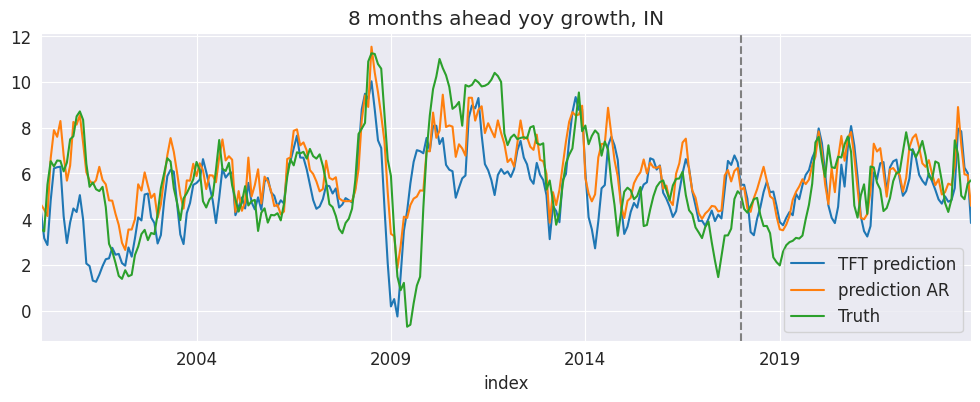

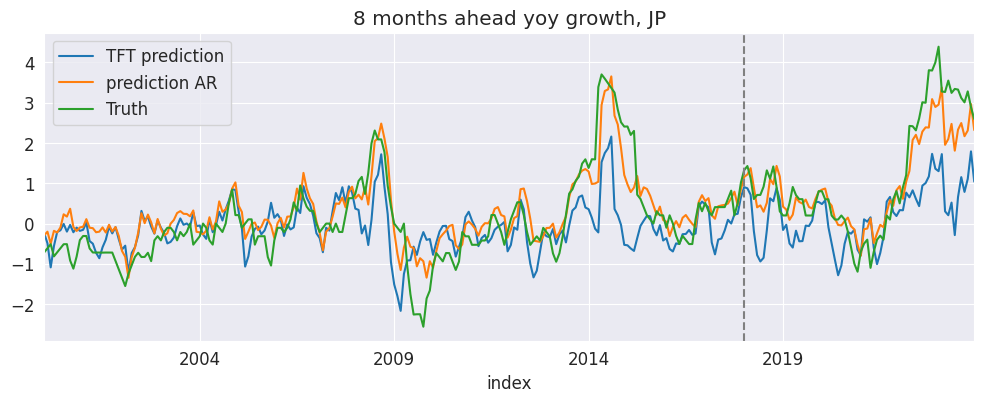

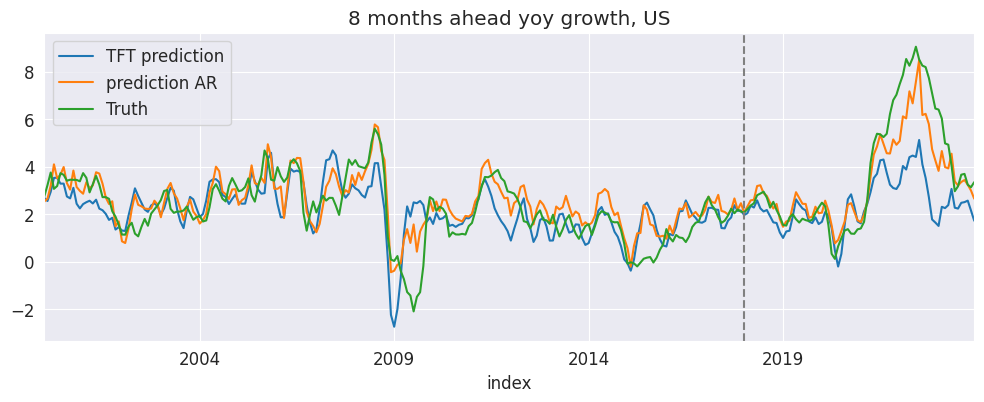

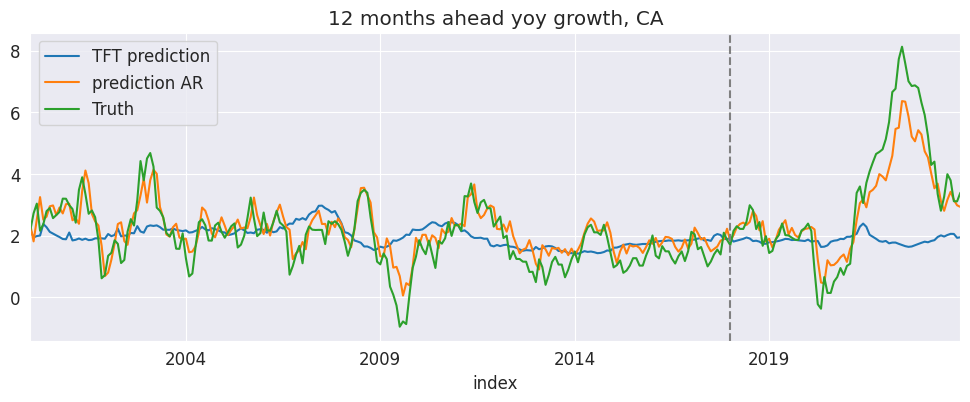

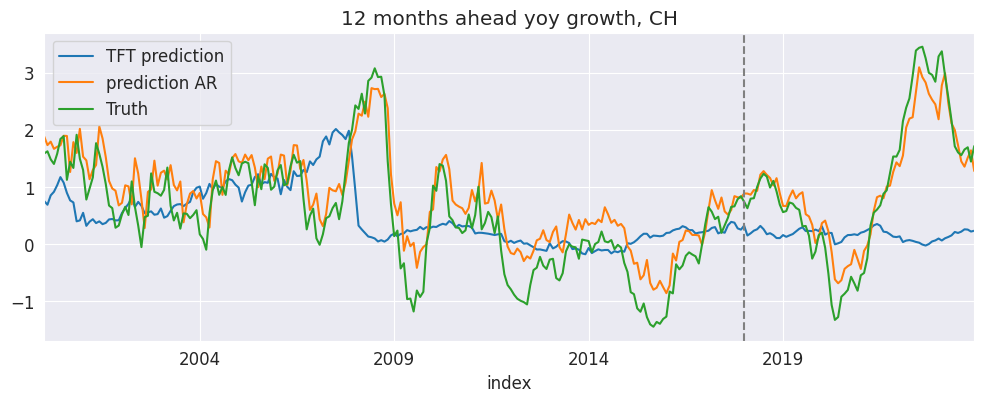

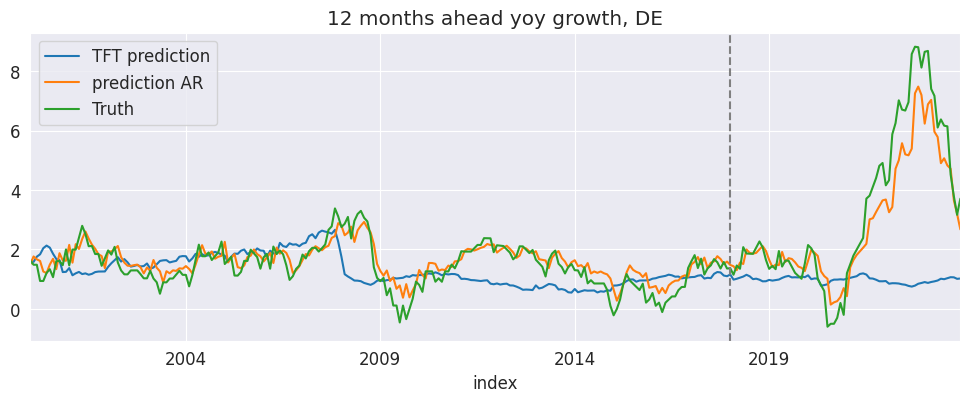

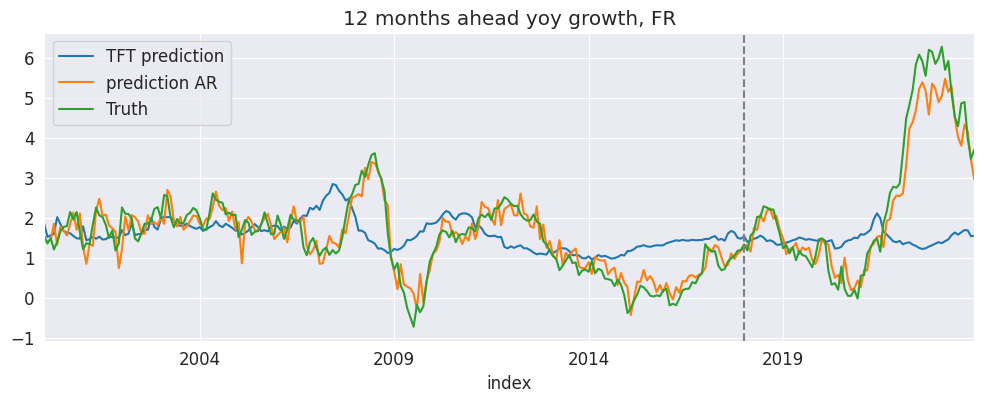

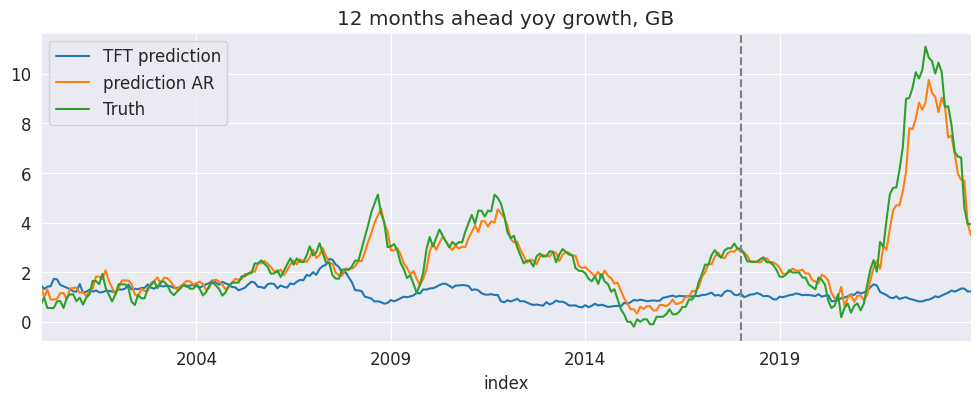

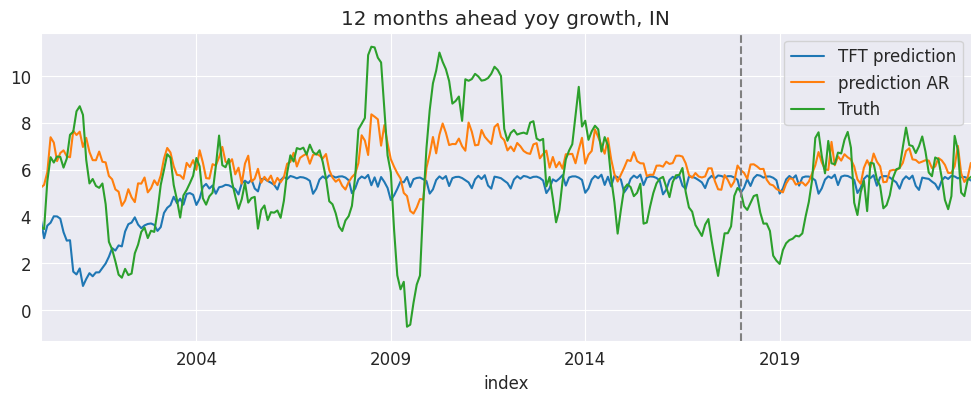

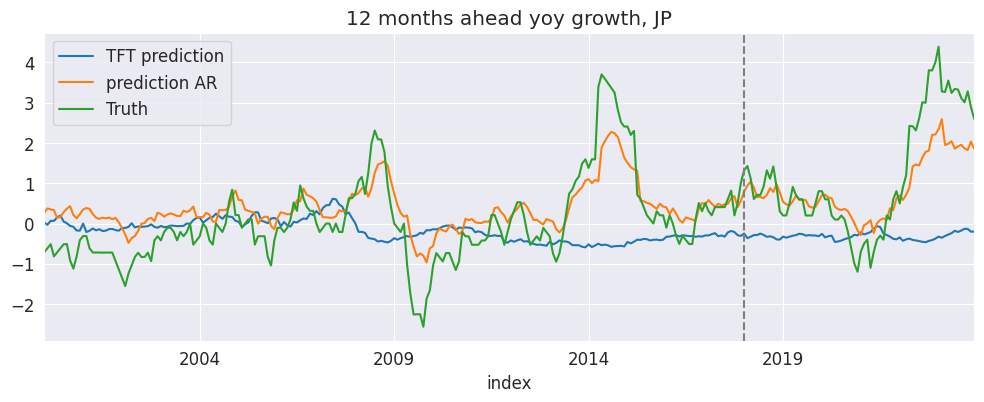

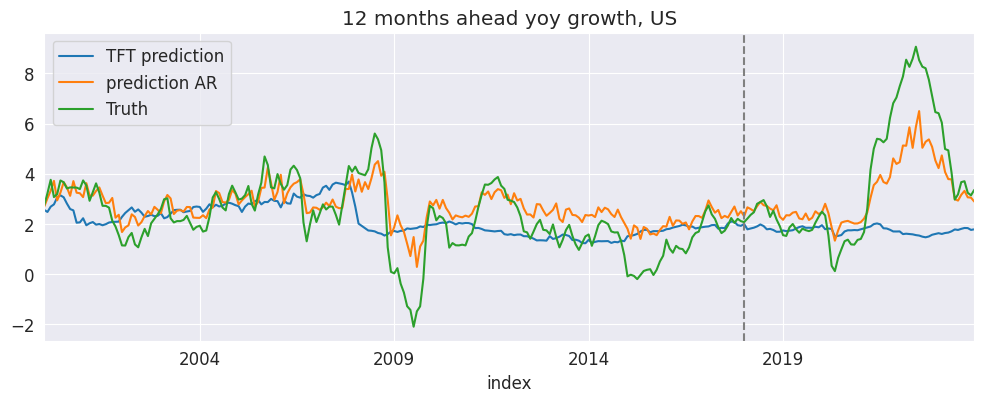

In [84]:
for n_months_ahead in [1, 2, 4, 8, 12]:
    for country in tft.countries:
        yoy_plot("2000-01-01", "2023-12-01", country, n_months_ahead)

<Axes: xlabel='0'>

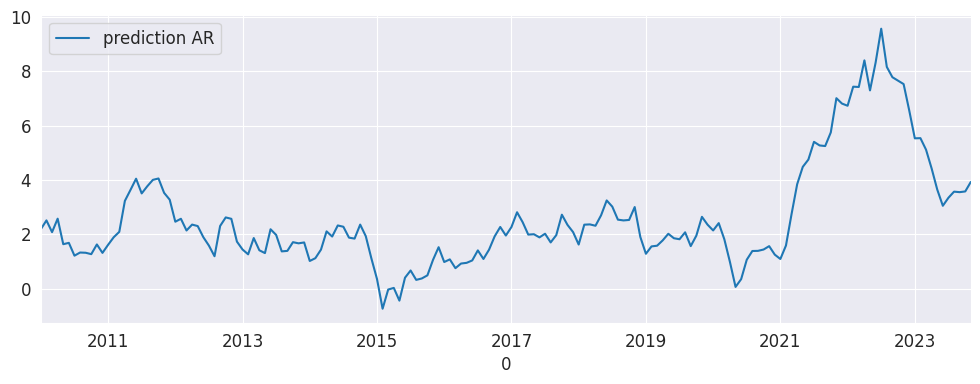

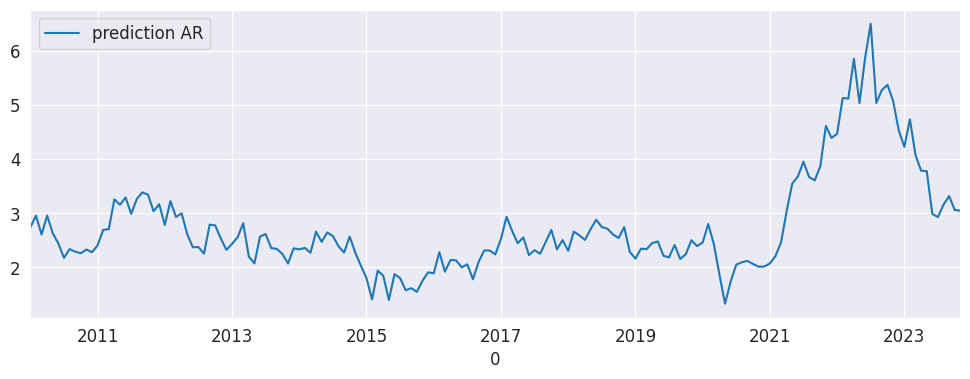

In [86]:

generate_ar_forecast(start_date, end_date, "US", 2).plot()
generate_ar_forecast(start_date, end_date, "US", 12).plot()


In [ ]:
models["TFT_full"].predict(X).shape